INSTALL THE FOLLOWING PYTHON PACKAGES FIRST BEFORE RUNNING THE PROGRAM

1) Numpy
2) NNFS - for the Spiral dataset
3) scikit-learn - for the iris dataset

In [1]:
# Library imports
import numpy as np

Create classes for modularity

In [2]:
# Hidden Layers
# Dense
class Layer_Dense:
    # Layer initialization
    # randomly initialize weights and set biases to zero
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))


    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [3]:
# Activation Functions
# Included here are the functions for both the forward and backward pass

# Linear
class ActivationLinear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

# Sigmoid
class ActivationSigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))

# TanH
class ActivationTanH:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ** 2)

# ReLU
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [4]:
# Loss functions

class Loss:
    # Calculate the data and regularization losses
    # Given the model output and grou truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

# MSE
class Loss_MSE:
    def forward(self, y_pred, y_true):
        # Calculate Mean Squared Error
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, y_pred, y_true):
        # Gradient of MSE loss
        samples = y_true.shape[0]
        outputs = y_true.shape[1]
        self.dinputs = -2 * (y_true - y_pred) / outputs
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Binary Cross-Entropy
class Loss_BinaryCrossEntropy:
    def forward(self, y_pred, y_true):
        # Clip predictions
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate Binary Cross Entropy
        return -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))

    def backward(self, y_pred, y_true):
        # Gradient of BCE loss
        samples = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        self.dinputs = - (y_true / y_pred_clipped - (1 - y_true) / (1 - y_pred_clipped))
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Categorical Cross-Entropy
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # Use the first sample to count them
        labels = len(dvalues[0])

        # Check if labels are sparse, turn them into one-hot vector values
        # the eye function creates a 2D array with ones on the diagonal and zeros elsewhere
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate the gradient
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples


<!-- Star -->

In [5]:
# Start of Optimizers

class Optimizer_SGD:
    # Initialie the optimizer - default learning rate to 1
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0, use_adagrad=False, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.use_adagrad = use_adagrad
        self.epsilon = epsilon
        self.iterations = 0

    def pre_update_params(self):
        #learning rate decay
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))

    # Update the parameters
    def update_params(self, layer):
        #momentum
        if self.momentum:
            if not hasattr(layer, 'weights_momentums'):
                layer.weights_momentums = np.zeros_like(layer.weights)
                layer.biases_momentums = np.zeros_like(layer.biases)

        # adagrad
        if self.use_adagrad:
            if not hasattr(layer, 'weight_cache'):
                layer.weight_cache = np.zeros_like(layer.weights)
                layer.bias_cache = np.zeros_like(layer.biases)

        if self.momentum:
            weight_updates = self.momentum * layer.weights_momentums - self.current_learning_rate * layer.dweights
            layer.weights_momentums = weight_updates

            bias_updates = self.momentum * layer.biases_momentums - self.current_learning_rate * layer.dbiases
            layer.biases_momentums = bias_updates

        else:
            weight_updates =  -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        if self.use_adagrad:
            layer.weight_cache += layer.dweights ** 2
            layer.bias_cache += layer.dbiases ** 2

            layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
            layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

        else:
            layer.weights += weight_updates
            layer.biases += bias_updates

    
    def post_update_params(self):
        self.iterations += 1

Use most of the classes to create a functioning neural network, capable of performing a forward and backward pass

We can use a sample dataset from the Spiral module.  

We can also use the IRIS dataset.

In [6]:
# Spiral Data
import nnfs
from nnfs.datasets import spiral_data

# Create the dataset
X, y = spiral_data(samples = 100, classes = 3)

# print(X[:5])
# print(X.shape)
# print(y[:5])
# print(y.shape)

In [7]:
# Iris Dataset
# From the scikit-learn library
# from sklearn.datasets import load_iris
# iris = load_iris()
# X = iris.data # Features
# y = iris.target # Target labels

# print(X[:5])
# print(X.shape)
# print(y[:5])
# print(y.shape)

In [8]:
# Neural Network initialization
# Create a Dense Layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Make sure you check the shape of the features, in order to adjust the input size of the first layer
# dense1 = Layer_Dense(4, 3)

# Create a ReLU activation for the first Dense layer
activation1 = Activation_ReLU()

# Create a 2nd dense layer with 3 input and 3 output values
dense2 = Layer_Dense(3, 3)

# Create a Softmax activation for the 2nd Dense layer
activation2 = Activation_Softmax()

# Create a loss function
loss_function = Loss_CategoricalCrossEntropy()

# Create the optimizer
optimizer = Optimizer_SGD()

PERFORM ONLY 1 PASS

In [9]:
# Perform a forward pass of our training data
# give the input from the dataset to the first layer
dense1.forward(X)

# Activation function
activation1.forward(dense1.output)

# Pass on the 2nd layer
dense2.forward(activation1.output)

activation2.forward(dense2.output)

# Calculate the loss
loss_function.forward(activation2.output, y)

# Check the model's performance
predictions = np.argmax(activation2.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)

# Print the accuracy
print('acc:', accuracy)

acc: 0.31333333333333335


In [10]:
# Perform a backward pass of our training data
# From loss to 2nd softmax activation
loss_function.backward(activation2.output, y)
dvalues = loss_function.dinputs # Gradient of the loss w.r.t softmax output

print(dvalues.shape)
# print(dvalues)

# From 2nd softmax to 2nd dense layer
activation2.backward(dvalues)
# From 2nd dense layer to 1st ReLU activation
dense2.backward(activation2.dinputs)

# From 1st ReLU activation to 1st dense layer
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

(300, 3)


In [11]:
# Check the gradient values of the weights and biases of the established layers
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)


# Update the weights and biases
optimizer.update_params(dense1)
optimizer.update_params(dense2)

[[ 6.18968702e-06 -3.71859614e-04 -1.96476123e-06]
 [ 3.57417354e-04  3.19202903e-04 -1.32898051e-05]]
[[ 9.17789324e-04 -8.54123623e-04  2.86720464e-05]]
[[ 1.42002669e-04 -3.73539293e-04  2.31536624e-04]
 [-7.70221393e-05 -4.43144704e-05  1.21336610e-04]
 [-5.25334860e-05  1.45992558e-04 -9.34590721e-05]]
[[ 1.17510376e-05 -1.83586817e-05  6.60764411e-06]]


### 1000 epochs


In [12]:
# weight update in 1000 epochs
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()

learning_rate = 1.0

epochs = 1000
for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    loss = loss_function.calculate(activation2.output, y)
    
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
    
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    dense1.weights += -learning_rate * dense1.dweights
    dense1.biases += -learning_rate * dense1.dbiases
    dense2.weights += -learning_rate * dense2.dweights
    dense2.biases += -learning_rate * dense2.dbiases

print(f'\nFinal - Epoch: {epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch: 0, Loss: 1.0986, Accuracy: 0.2767
Epoch: 100, Loss: 1.0985, Accuracy: 0.4300
Epoch: 100, Loss: 1.0985, Accuracy: 0.4300
Epoch: 200, Loss: 1.0783, Accuracy: 0.4067
Epoch: 200, Loss: 1.0783, Accuracy: 0.4067
Epoch: 300, Loss: 1.0769, Accuracy: 0.4000
Epoch: 300, Loss: 1.0769, Accuracy: 0.4000
Epoch: 400, Loss: 1.0769, Accuracy: 0.4000
Epoch: 400, Loss: 1.0769, Accuracy: 0.4000
Epoch: 500, Loss: 1.0768, Accuracy: 0.4033
Epoch: 500, Loss: 1.0768, Accuracy: 0.4033
Epoch: 600, Loss: 1.0764, Accuracy: 0.4000
Epoch: 600, Loss: 1.0764, Accuracy: 0.4000
Epoch: 700, Loss: 1.0753, Accuracy: 0.4133
Epoch: 700, Loss: 1.0753, Accuracy: 0.4133
Epoch: 800, Loss: 1.0733, Accuracy: 0.4067
Epoch: 800, Loss: 1.0733, Accuracy: 0.4067
Epoch: 900, Loss: 1.0716, Accuracy: 0.4233
Epoch: 900, Loss: 1.0716, Accuracy: 0.4233

Final - Epoch: 1000, Loss: 1.0709, Accuracy: 0.4400

Final - Epoch: 1000, Loss: 1.0709, Accuracy: 0.4400


Learning Rate Decay

In [13]:
# learning rate decay
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()

optimizer = Optimizer_SGD(learning_rate=1.0, decay=0.001)

epochs = 1000
for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    loss = loss_function.calculate(activation2.output, y)
    
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, LR: {optimizer.current_learning_rate:.6f}')
    
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

print(f'\nFinal - Epoch: {epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch: 0, Loss: 1.0986, Accuracy: 0.2300, LR: 1.000000
Epoch: 100, Loss: 1.0983, Accuracy: 0.4200, LR: 0.909918
Epoch: 100, Loss: 1.0983, Accuracy: 0.4200, LR: 0.909918
Epoch: 200, Loss: 1.0777, Accuracy: 0.4433, LR: 0.834028
Epoch: 200, Loss: 1.0777, Accuracy: 0.4433, LR: 0.834028
Epoch: 300, Loss: 1.0719, Accuracy: 0.4233, LR: 0.769823
Epoch: 300, Loss: 1.0719, Accuracy: 0.4233, LR: 0.769823
Epoch: 400, Loss: 1.0699, Accuracy: 0.4300, LR: 0.714796
Epoch: 400, Loss: 1.0699, Accuracy: 0.4300, LR: 0.714796
Epoch: 500, Loss: 1.0695, Accuracy: 0.4267, LR: 0.667111
Epoch: 500, Loss: 1.0695, Accuracy: 0.4267, LR: 0.667111
Epoch: 600, Loss: 1.0693, Accuracy: 0.4300, LR: 0.625391
Epoch: 600, Loss: 1.0693, Accuracy: 0.4300, LR: 0.625391
Epoch: 700, Loss: 1.0692, Accuracy: 0.4333, LR: 0.588582
Epoch: 700, Loss: 1.0692, Accuracy: 0.4333, LR: 0.588582
Epoch: 800, Loss: 1.0690, Accuracy: 0.4300, LR: 0.555864
Epoch: 800, Loss: 1.0690, Accuracy: 0.4300, LR: 0.555864
Epoch: 900, Loss: 1.0688, Accurac

Momentum


In [14]:
dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()

optimizer = Optimizer_SGD(learning_rate=1.0, momentum=0.9)

epochs = 1000
for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    loss = loss_function.calculate(activation2.output, y)

    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, LR: {optimizer.current_learning_rate:.6f}')

    loss_function.backward(activation2.output, y)       
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

print(f'\nFinal - Epoch: {epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch: 0, Loss: 1.0986, Accuracy: 0.2267, LR: 1.000000
Epoch: 100, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 100, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 200, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 200, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 300, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 300, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 400, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 400, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 500, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 500, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 600, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 600, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 700, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 700, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 800, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 800, Loss: 1.0760, Accuracy: 0.3800, LR: 1.000000
Epoch: 900, Loss: 1.0760, Accurac

Adagrad

In [15]:

dense1 = Layer_Dense(2, 3)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)
activation2 = Activation_Softmax()
loss_function = Loss_CategoricalCrossEntropy()

optimizer = Optimizer_SGD(learning_rate=1.0, use_adagrad=True)

epochs = 1000
for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    loss = loss_function.calculate(activation2.output, y)
    
    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y_labels = np.argmax(y, axis=1)
    else:
        y_labels = y
    accuracy = np.mean(predictions == y_labels)
    
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
    
    loss_function.backward(activation2.output, y)
    activation2.backward(loss_function.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

print(f'\nFinal - Epoch: {epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch: 0, Loss: 1.0986, Accuracy: 0.3600
Epoch: 100, Loss: 1.0713, Accuracy: 0.4200
Epoch: 100, Loss: 1.0713, Accuracy: 0.4200
Epoch: 200, Loss: 1.0713, Accuracy: 0.4300
Epoch: 200, Loss: 1.0713, Accuracy: 0.4300
Epoch: 300, Loss: 1.0684, Accuracy: 0.4400
Epoch: 300, Loss: 1.0684, Accuracy: 0.4400
Epoch: 400, Loss: 1.0672, Accuracy: 0.4267
Epoch: 400, Loss: 1.0672, Accuracy: 0.4267
Epoch: 500, Loss: 1.0647, Accuracy: 0.4100
Epoch: 500, Loss: 1.0647, Accuracy: 0.4100
Epoch: 600, Loss: 1.0634, Accuracy: 0.4233
Epoch: 600, Loss: 1.0634, Accuracy: 0.4233
Epoch: 700, Loss: 1.0627, Accuracy: 0.4433
Epoch: 700, Loss: 1.0627, Accuracy: 0.4433
Epoch: 800, Loss: 1.0622, Accuracy: 0.4600
Epoch: 800, Loss: 1.0622, Accuracy: 0.4600
Epoch: 900, Loss: 1.0622, Accuracy: 0.4467
Epoch: 900, Loss: 1.0622, Accuracy: 0.4467

Final - Epoch: 1000, Loss: 1.0621, Accuracy: 0.4467

Final - Epoch: 1000, Loss: 1.0621, Accuracy: 0.4467


## Comparison of Optimizers

In [19]:
# comparisons
import matplotlib.pyplot as plt

# Function to detect when loss stabilizes (change is less than threshold)
def find_stabilization_epoch(losses, threshold=0.001, window=50):
    for i in range(window, len(losses)):
        recent_losses = losses[i-window:i]
        loss_change = max(recent_losses) - min(recent_losses)
        if loss_change < threshold:
            return i
    return len(losses)  # If never stabilizes, return total epochs

# Store results for each optimizer
results = {}
optimizers_to_test = [
    ("Vanilla SGD + Decay", {"learning_rate": 1.0, "decay": 1e-3}),
    ("Momentum + Decay", {"learning_rate": 1.0, "decay": 1e-3, "momentum": 0.9}),
    ("AdaGrad + Decay", {"learning_rate": 1.0, "decay": 1e-3, "use_adagrad": True})
]


for optimizer_name, optimizer_params in optimizers_to_test:
    print(f"\n{optimizer_name}...")
    
    # Reinitialize network for fair comparison
    dense1 = Layer_Dense(2, 3)
    activation1 = Activation_ReLU()
    dense2 = Layer_Dense(3, 3)
    activation2 = Activation_Softmax()
    loss_function = Loss_CategoricalCrossEntropy()
    optimizer = Optimizer_SGD(**optimizer_params)
    
    # Track metrics
    losses = []
    accuracies = []
    
    # Train for 1000 epochs
    epochs = 1000
    for epoch in range(epochs):
        # Forward Pass
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        loss = loss_function.calculate(activation2.output, y)
        
        # Calculate accuracy 
        predictions = np.argmax(activation2.output, axis=1)
        if len(y.shape) == 2:
            y_labels = np.argmax(y, axis=1)
        else:
            y_labels = y
        accuracy = np.mean(predictions == y_labels)
        
        # Store metrics
        losses.append(loss)
        accuracies.append(accuracy)
        
        # Backward Pass
        loss_function.backward(activation2.output, y)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        
        # Weight Update
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()
    
    # Find stabilization epoch
    stabilization_epoch = find_stabilization_epoch(losses)
    
    # Store results
    results[optimizer_name] = {
        'losses': losses,
        'accuracies': accuracies,
        'final_loss': losses[-1],
        'final_accuracy': accuracies[-1],
        'stabilization_epoch': stabilization_epoch,
        'best_accuracy': max(accuracies)
    }


Vanilla SGD + Decay...

Momentum + Decay...

Momentum + Decay...

AdaGrad + Decay...

AdaGrad + Decay...


Model Accuracy

In [24]:
# Display
for optimizer_name, metrics in results.items():
    stabilization = metrics['stabilization_epoch']
    print(f"\n{optimizer_name}:")
    print(f"  → Loss stabilized at epoch: {stabilization}")
    print(f"  → Loss at stabilization: {metrics['losses'][min(stabilization-1, len(metrics['losses'])-1)]:.4f}")

for optimizer_name, metrics in results.items():
    print(f"\n{optimizer_name}:")
    print(f"  → Final Accuracy: {metrics['final_accuracy']:.4f} ({metrics['final_accuracy']*100:.2f}%)")
    print(f"  → Best Accuracy:  {metrics['best_accuracy']:.4f} ({metrics['best_accuracy']*100:.2f}%)")
    print(f"  → Final Loss:     {metrics['final_loss']:.4f}")


print("\n{:<25} {:<20} {:<20} {:<15}".format(
    "Optimizer", "Stabilization Epoch", "Final Accuracy", "Final Loss"))
print("-" * 80)

for optimizer_name, metrics in results.items():
    print("{:<25} {:<20} {:<20} {:<15}".format(
        optimizer_name,
        str(metrics['stabilization_epoch']),
        f"{metrics['final_accuracy']:.4f} ({metrics['final_accuracy']*100:.1f}%)",
        f"{metrics['final_loss']:.4f}"
    ))

# Determine best optimizer for each metric
best_stabilization = min(results.items(), key=lambda x: x[1]['stabilization_epoch'])
best_accuracy = max(results.items(), key=lambda x: x[1]['final_accuracy'])

print(f"\nFastest to stabilize: {best_stabilization[0]}")
print(f"Stabilized at epoch {best_stabilization[1]['stabilization_epoch']}")
print(f"\nHighest accuracy: {best_accuracy[0]}")
print(f"Final accuracy: {best_accuracy[1]['final_accuracy']:.4f} ({best_accuracy[1]['final_accuracy']*100:.2f}%)")




Vanilla SGD + Decay:
  → Loss stabilized at epoch: 50
  → Loss at stabilization: 1.0985

Momentum + Decay:
  → Loss stabilized at epoch: 122
  → Loss at stabilization: 1.0640

AdaGrad + Decay:
  → Loss stabilized at epoch: 158
  → Loss at stabilization: 1.0711

Vanilla SGD + Decay:
  → Final Accuracy: 0.4400 (44.00%)
  → Best Accuracy:  0.4433 (44.33%)
  → Final Loss:     1.0659

Momentum + Decay:
  → Final Accuracy: 0.4333 (43.33%)
  → Best Accuracy:  0.4733 (47.33%)
  → Final Loss:     1.0331

AdaGrad + Decay:
  → Final Accuracy: 0.4267 (42.67%)
  → Best Accuracy:  0.4367 (43.67%)
  → Final Loss:     1.0691

Optimizer                 Stabilization Epoch  Final Accuracy       Final Loss     
--------------------------------------------------------------------------------
Vanilla SGD + Decay       50                   0.4400 (44.0%)       1.0659         
Momentum + Decay          122                  0.4333 (43.3%)       1.0331         
AdaGrad + Decay           158                  0

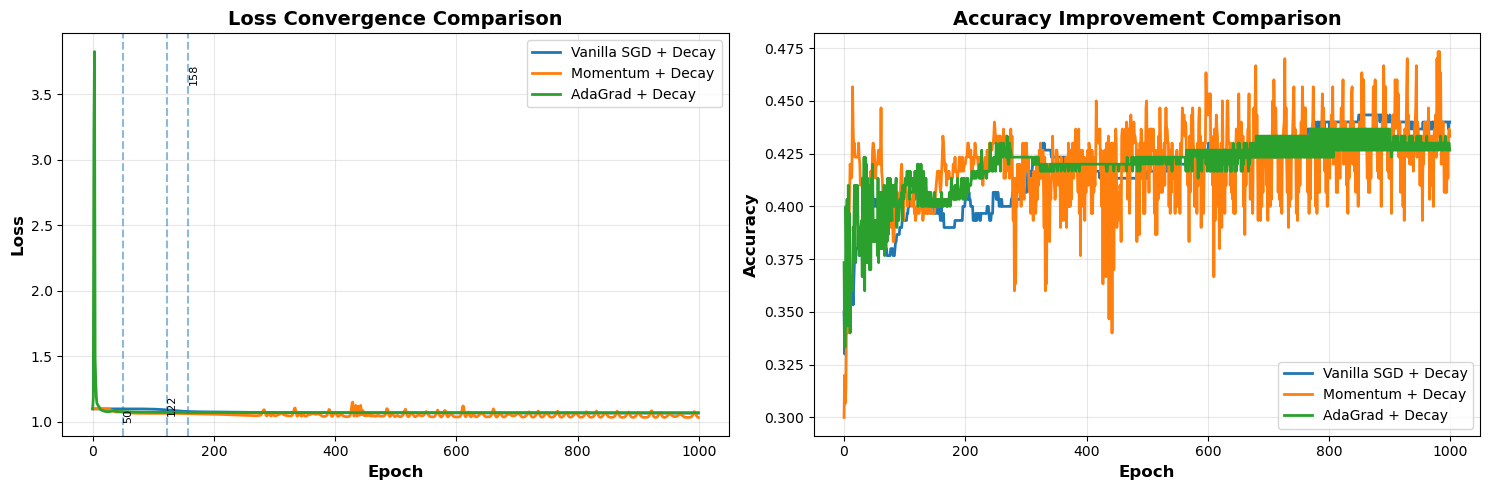

In [23]:
# Visualize the comparison with graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Loss over epochs
ax1 = axes[0]
for optimizer_name, metrics in results.items():
    ax1.plot(metrics['losses'], label=optimizer_name, linewidth=2)
    # Mark stabilization point
    stab_epoch = metrics['stabilization_epoch']
    if stab_epoch < len(metrics['losses']):
        ax1.axvline(x=stab_epoch, linestyle='--', alpha=0.5)
        ax1.text(stab_epoch, ax1.get_ylim()[1]*0.9, f'{stab_epoch}', 
                rotation=90, verticalalignment='bottom', fontsize=8)

ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss Convergence Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy over epochs
ax2 = axes[1]
for optimizer_name, metrics in results.items():
    ax2.plot(metrics['accuracies'], label=optimizer_name, linewidth=2)

ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Improvement Comparison', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
